
Solution template for the question 1.6-1.7. This template consists of following steps. Except the step 2, you don't need to modify it to answer the questions.
1.   Initialize libraries
2.   **Insert the answers for the questions 1.1~1.5 below (this is the part you need to fill)**
3.   Define data loaders
4.   Define VAE network architecture
5.   Initialize the model and optimizer
6.   Train the model
7.   Save the model
8.   Load the model
9.   Evaluate the model with importance sampling

Initialize libraries

In [1]:
import math
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

Insert **the answers for the questions 1.1~1.5 below**

In [2]:
def log_likelihood_bernoulli(mu, target):
    """ 
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** note. ***

    :param mu: (FloatTensor) - shape: (batch_size x input_size) - The mean of Bernoulli random variables p(x=1).
    :param target: (FloatTensor) - shape: (batch_size x input_size) - Target samples (binary values).
    :return: (FloatTensor) - shape: (batch_size,) - log-likelihood of target samples on the Bernoulli random variables.
    """
    # init
    batch_size = mu.size(0)
    mu = mu.view(batch_size, -1)
    target = target.view(batch_size, -1)

    # log_likelihood_bernoulli
    # L = log (mu^tar * (1-mu)^(1-t)) = tar*log(mu) + (1-tar)log(1-mu)
    return torch.sum(target * torch.log(mu) + (1-target) * torch.log(1-mu), dim=1)


def log_likelihood_normal(mu, logvar, z):
    """ 
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** note. ***

    :param mu: (FloatTensor) - shape: (batch_size x input_size) - The mean of Normal distributions.
    :param logvar: (FloatTensor) - shape: (batch_size x input_size) - The log variance of Normal distributions.
    :param z: (FloatTensor) - shape: (batch_size x input_size) - Target samples.
    :return: (FloatTensor) - shape: (batch_size,) - log probability of the sames on the given Normal distributions.
    """
    # init
    batch_size = mu.size(0)
    mu = mu.view(batch_size, -1)
    logvar = logvar.view(batch_size, -1)
    z = z.view(batch_size, -1)

    # log normal
    # L = log (1/(sd*sqrt(2*pi))exp(-1/2((x-mu)/sd)^2)) = -log(sd*sqrt(2*pi)) -1/2((x-mu)/sd)^2)
    # L = -log(sqrt(2*pi*var) - 1/2((x-mu)^2/var))
    var = torch.exp(logvar)
    return torch.sum(-torch.log((2*np.pi*var)**0.5) - (z-mu)**2/(2*var), dim=1)


def log_mean_exp(y):
    """ 
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** note. ***

    :param y: (FloatTensor) - shape: (batch_size x sample_size) - Values to be evaluated for log_mean_exp. For example log proababilies
    :return: (FloatTensor) - shape: (batch_size,) - Output for log_mean_exp.
    """
    # init
    batch_size = y.size(0)
    sample_size = y.size(1)

    # log_mean_exp = log(1/k* sum^k(exp(y_i^k-a_i))) + a_i
    y_max, idx = torch.max(y, dim=1)
    y_max = y_max.reshape(-1,1) # reshape: (batch_size, )
    return torch.log(torch.mean(torch.exp(y - y_max), dim=1, keepdim=True)) + y_max 


def kl_gaussian_gaussian_analytic(mu_q, logvar_q, mu_p, logvar_p):
    """ 
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** note. ***

    :param mu_q: (FloatTensor) - shape: (batch_size x input_size) - The mean of first distributions (Normal distributions).
    :param logvar_q: (FloatTensor) - shape: (batch_size x input_size) - The log variance of first distributions (Normal distributions).
    :param mu_p: (FloatTensor) - shape: (batch_size x input_size) - The mean of second distributions (Normal distributions).
    :param logvar_p: (FloatTensor) - shape: (batch_size x input_size) - The log variance of second distributions (Normal distributions).
    :return: (FloatTensor) - shape: (batch_size,) - kl-divergence of KL(q||p).
    """
    # init
    batch_size = mu_q.size(0)
    mu_q = mu_q.view(batch_size, -1)
    logvar_q = logvar_q.view(batch_size, -1)
    mu_p = mu_p.view(batch_size, -1)
    logvar_p = logvar_p.view(batch_size, -1)

    # kld
    # ref: https://en.wikipedia.org/wiki/Kullback–Leibler_divergence#Multivariate_normal_distributions
    # D_KL[q||p] = 1/2(trace(var_p ^{-1} var_q) + (mu_p - mu_q)^T var_p ^{-1} (mu_p - mu_q) - input_size + log(det_p/det_q))
    diff_mu = mu_p - mu_q
    
    trace = torch.sum(torch.exp(logvar_q - logvar_p), dim=1)
    diff_inv_diff = torch.sum(diff_mu / torch.exp(logvar_p) * diff_mu, dim=1)
    input_size = mu_q.size(1)
    log = torch.sum(logvar_p, dim=1) - torch.sum(logvar_q, dim=1) # shape: (batch_size, 1)
    
    return (trace + diff_inv_diff - input_size + log) / 2


def kl_gaussian_gaussian_mc(mu_q, logvar_q, mu_p, logvar_p, num_samples=1):
    """ 
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** note. ***

    :param mu_q: (FloatTensor) - shape: (batch_size x input_size) - The mean of first distributions (Normal distributions).
    :param logvar_q: (FloatTensor) - shape: (batch_size x input_size) - The log variance of first distributions (Normal distributions).
    :param mu_p: (FloatTensor) - shape: (batch_size x input_size) - The mean of second distributions (Normal distributions).
    :param logvar_p: (FloatTensor) - shape: (batch_size x input_size) - The log variance of second distributions (Normal distributions).
    :param num_samples: (int) - shape: () - The number of sample for Monte Carlo estimate for KL-divergence
    :return: (FloatTensor) - shape: (batch_size,) - kl-divergence of KL(q||p).
    """
    # init
    batch_size = mu_q.size(0)
    input_size = np.prod(mu_q.size()[1:])
    mu_q = mu_q.view(batch_size, -1).unsqueeze(1).expand(batch_size, num_samples, input_size)
    logvar_q = logvar_q.view(batch_size, -1).unsqueeze(1).expand(batch_size, num_samples, input_size)
    mu_p = mu_p.view(batch_size, -1).unsqueeze(1).expand(batch_size, num_samples, input_size)
    logvar_p = logvar_p.view(batch_size, -1).unsqueeze(1).expand(batch_size, num_samples, input_size)

    # kld
    # define the distributions
    q = torch.distributions.MultivariateNormal(mu_q, torch.diag_embed(torch.exp(logvar_q)))
    p = torch.distributions.MultivariateNormal(mu_p, torch.diag_embed(torch.exp(logvar_p)))
    z = q.sample()
    
    return torch.mean(q.log_prob(z) - p.log_prob(z), dim=1)

Define data loaders

In [3]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [4]:
train, valid, test = get_data_loader("binarized_mnist", 64)

Using downloaded and verified file: binarized_mnist/binarized_mnist_train.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_valid.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_test.amat


Define VAE network architecture


In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * latent_size),
        )

    def forward(self, x):
        batch_size = x.size(0)
        z_mean, z_logvar = self.mlp(x.view(batch_size, 784)).chunk(2, dim=-1)
        return z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_size, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784),
        )
        
    def forward(self, z):
        return self.mlp(z) - 5.

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.encode = Encoder(latent_size)
        self.decode = Decoder(latent_size)

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z_sample = z_mean + torch.exp(z_logvar / 2.) * torch.randn_like(z_logvar)
        x_mean = self.decode(z_sample)
        return z_mean, z_logvar, x_mean

    def loss(self, x, z_mean, z_logvar, x_mean):
        ZERO = torch.zeros(z_mean.size())
        #kl = kl_gaussian_gaussian_mc(z_mean, z_logvar, ZERO, ZERO, num_samples=1000).mean()
        kl = kl_gaussian_gaussian_analytic(z_mean, z_logvar, ZERO, ZERO).mean()
        recon_loss = -log_likelihood_bernoulli(
            torch.sigmoid(x_mean.view(x.size(0), -1)),
            x.view(x.size(0), -1),            
        ).mean()
        return recon_loss + kl

Initialize a model and optimizer

In [6]:
vae = VAE(100)
params = vae.parameters()
optimizer = Adam(params, lr=3e-4)
print(vae)

VAE(
  (encode): Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=784, out_features=300, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=300, out_features=300, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=300, out_features=200, bias=True)
    )
  )
  (decode): Decoder(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=300, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=300, out_features=300, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=300, out_features=784, bias=True)
    )
  )
)


Train the model

In [7]:
for i in range(20):
    # train
    for x in train:
        optimizer.zero_grad()
        z_mean, z_logvar, x_mean = vae(x)
        loss = vae.loss(x, z_mean, z_logvar, x_mean)
        loss.backward()
        optimizer.step()

    # evaluate ELBO on the valid dataset
    with torch.no_grad():
        total_loss = 0.
        total_count = 0
        for x in valid:
            total_loss += vae.loss(x, *vae(x)) * x.size(0)
            total_count += x.size(0)
        print('-elbo: ', (total_loss / total_count).item())

-elbo:  167.93463134765625
-elbo:  144.76071166992188
-elbo:  130.29869079589844
-elbo:  122.106689453125
-elbo:  116.83917236328125
-elbo:  113.26568603515625
-elbo:  111.04727172851562
-elbo:  109.50458526611328
-elbo:  107.87423706054688
-elbo:  107.1313247680664
-elbo:  106.11711120605469
-elbo:  105.00074768066406
-elbo:  104.54178619384766
-elbo:  103.69232940673828
-elbo:  103.34203338623047
-elbo:  102.83753204345703
-elbo:  102.25534057617188
-elbo:  101.78614044189453
-elbo:  101.39635467529297
-elbo:  101.4257583618164


Save the model

In [8]:
torch.save(vae, 'model.pt')

/Users/lucas/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/lucas/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/lucas/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Load the model

In [9]:
vae = torch.load('model.pt')

Evaluate the $\log p_\theta(x)$ of the model on test by using importance sampling

In [10]:
total_loss = 0.
total_count = 0
arr = []
with torch.no_grad():
    #x = next(iter(test))
    for x in test:
        # init
        K = 200
        M = x.size(0)

        # Sample from the posterior
        z_mean, z_logvar = vae.encode(x)
        eps = torch.randn(z_mean.size(0), K, z_mean.size(1))
        z_samples = z_mean[:, None, :] + torch.exp(z_logvar / 2.)[:, None, :] * eps # Broadcast the noise over the mean and variance

        # Decode samples
        z_samples_flat = z_samples.view(-1, z_samples.size(-1)) # Flatten out the z samples
        x_mean_flat = vae.decode(z_samples_flat) # Push it through

        # Reshape images and posterior to evaluate probabilities
        x_flat = x[:, None].repeat(1, K, 1, 1, 1).reshape(M*K, -1)
        z_mean_flat = z_mean[:, None, :].expand_as(z_samples).reshape(M*K, -1)
        z_logvar_flat =  z_logvar[:, None, :].expand_as(z_samples).reshape(M*K, -1)
        ZEROS = torch.zeros(z_mean_flat.size())

        # Calculate all the probabilities!
        log_p_x_z = log_likelihood_bernoulli(torch.sigmoid(x_mean_flat), x_flat).view(M, K)
        log_q_z_x = log_likelihood_normal(z_mean_flat, z_logvar_flat, z_samples_flat).view(M, K)
        log_p_z = log_likelihood_normal(ZEROS, ZEROS, z_samples_flat).view(M, K)

        # Recombine them.
        w = log_p_x_z + log_p_z - log_q_z_x
        log_p = log_mean_exp(w)

        # Accumulate
        total_loss += log_p.sum()
        total_count += M
          
        arr.append((total_loss / total_count).item())
        
print('log p(x):', (total_loss / total_count).item())

log p(x): -95.62511444091797


In [11]:
total_loss = 0.
total_count = 0
arr = []
with torch.no_grad():
    #x = next(iter(test))
    for x in test:
        # init
        K = 200
        M = x.size(0)

        # Sample from the posterior
        z_mean, z_logvar = vae.encode(x)
        eps = torch.randn(z_mean.size(0), K, z_mean.size(1))
        z_samples = z_mean[:, None, :] + torch.exp(z_logvar / 2.)[:, None, :] * eps # Broadcast the noise over the mean and variance

        # Decode samples
        z_samples_flat = z_samples.view(-1, z_samples.size(-1)) # Flatten out the z samples
        x_mean_flat = vae.decode(z_samples_flat) # Push it through

        # Reshape images and posterior to evaluate probabilities
        x_flat = x[:, None].repeat(1, K, 1, 1, 1).reshape(M*K, -1)
        z_mean_flat = z_mean[:, None, :].expand_as(z_samples).reshape(M*K, -1)
        z_logvar_flat =  z_logvar[:, None, :].expand_as(z_samples).reshape(M*K, -1)
        ZEROS = torch.zeros(z_mean_flat.size())

        # Calculate all the probabilities!
        log_p_x_z = log_likelihood_bernoulli(torch.sigmoid(x_mean_flat), x_flat).view(M, K)
        log_q_z_x = log_likelihood_normal(z_mean_flat, z_logvar_flat, z_samples_flat).view(M, K)
        log_p_z = log_likelihood_normal(ZEROS, ZEROS, z_samples_flat).view(M, K)

        # Recombine them.
        w = log_p_x_z + log_p_z - log_q_z_x
        log_p = log_mean_exp(w)

        # Accumulate
        total_loss += log_p.sum()
        total_count += M
          
        arr.append((total_loss / total_count).item())
        
print('log p(x):', (total_loss / total_count).item())

log p(x): -95.60469055175781


In [12]:
print(arr)

[-103.39934539794922, -105.12080383300781, -105.7254409790039, -106.2130355834961, -105.33979797363281, -106.64531707763672, -106.3676528930664, -106.39151000976562, -106.56153869628906, -106.7182388305664, -106.00627136230469, -105.41098022460938, -105.68479919433594, -105.3115463256836, -105.6065673828125, -103.22181701660156, -99.87994384765625, -96.89378356933594, -94.44324493408203, -92.26286315917969, -90.27893829345703, -88.23207092285156, -86.52072143554688, -84.87870025634766, -83.45452880859375, -82.13642883300781, -80.92396545410156, -79.7956771850586, -78.77132415771484, -78.16651916503906, -77.27571105957031, -76.4686508178711, -75.82145690917969, -76.72113800048828, -77.82655334472656, -78.76113891601562, -79.55526733398438, -80.3714599609375, -81.00475311279297, -81.79635620117188, -82.47598266601562, -83.18425750732422, -84.010498046875, -84.7567367553711, -85.31884002685547, -86.08030700683594, -86.63522338867188, -87.23941040039062, -87.79821014404297, -88.21414184570

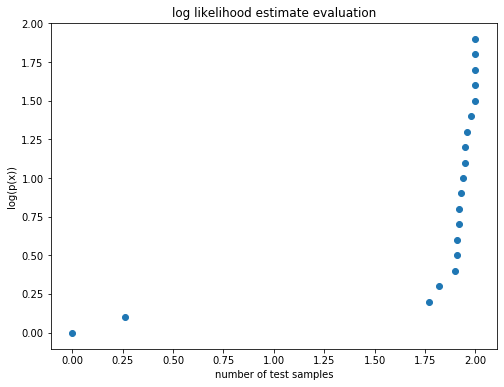

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import numpy as np

arr = [-103.39934539794922, -105.12080383300781, -105.7254409790039, -106.2130355834961, -105.33979797363281, -106.64531707763672, -106.3676528930664, -106.39151000976562, -106.56153869628906, -106.7182388305664, -106.00627136230469, -105.41098022460938, -105.68479919433594, -105.3115463256836, -105.6065673828125, -103.22181701660156, -99.87994384765625, -96.89378356933594, -94.44324493408203, -92.26286315917969, -90.27893829345703, -88.23207092285156, -86.52072143554688, -84.87870025634766, -83.45452880859375, -82.13642883300781, -80.92396545410156, -79.7956771850586, -78.77132415771484, -78.16651916503906, -77.27571105957031, -76.4686508178711, -75.82145690917969, -76.72113800048828, -77.82655334472656, -78.76113891601562, -79.55526733398438, -80.3714599609375, -81.00475311279297, -81.79635620117188, -82.47598266601562, -83.18425750732422, -84.010498046875, -84.7567367553711, -85.31884002685547, -86.08030700683594, -86.63522338867188, -87.23941040039062, -87.79821014404297, -88.21414184570312, -88.48722076416016, -88.69462585449219, -88.95362091064453, -89.18097686767578, -89.3722915649414, -89.6334228515625, -89.78434753417969, -90.12921142578125, -90.48308563232422, -90.6999282836914, -90.89405822753906, -91.14773559570312, -91.49398803710938, -91.72765350341797, -92.00224304199219, -92.06580352783203, -92.13318634033203, -92.22573852539062, -92.24687194824219, -92.3133316040039, -92.3404541015625, -92.3998031616211, -92.36315155029297, -92.41500854492188, -92.49224853515625, -92.5467300415039, -92.58564758300781, -92.67266082763672, -92.72310638427734, -92.83246612548828, -92.96803283691406, -93.1505126953125, -93.33452606201172, -93.55651092529297, -93.7217788696289, -93.93302917480469, -94.06253051757812, -94.21023559570312, -94.3924331665039, -94.54309844970703, -94.58939361572266, -94.70233154296875, -94.83222198486328, -94.9638900756836, -95.04743957519531, -95.11531829833984, -95.14979553222656, -95.24775695800781, -95.35542297363281, -95.38838195800781, -95.4591293334961, -95.49247741699219, -95.50346374511719, -95.53791809082031, -95.54264068603516, -95.54246520996094, -95.59041595458984, -95.59966278076172, -95.65459442138672, -95.58564758300781, -95.4929428100586, -95.38246154785156, -95.27938079833984, -95.1528091430664, -95.07061767578125, -95.00750732421875, -94.9329833984375, -94.7495346069336, -94.6191635131836, -94.49327850341797, -94.32564544677734, -94.19844818115234, -94.10403442382812, -94.06868743896484, -93.98704528808594, -94.09742736816406, -94.29055786132812, -94.49723815917969, -94.67912292480469, -94.80059051513672, -95.00746154785156, -95.1891098022461, -95.33344268798828, -95.44664001464844, -95.5848617553711, -95.74165344238281, -95.8671646118164, -95.98371124267578, -96.10555267333984, -96.2667236328125, -96.29009246826172, -96.2192153930664, -96.1932601928711, -96.15314483642578, -96.11573791503906, -96.088134765625, -96.06889343261719, -96.04296112060547, -96.00565338134766, -95.92762756347656, -95.90861511230469, -95.84281158447266, -95.75617218017578, -95.72946166992188, -95.66044616699219, -95.60722351074219, -95.60469055175781]
epochs = np.arange(157)

x = [0.00, 0.26, 1.77, 1.82, 1.9, 1.91, 1.91, 1.92, 1.92, 1.93, 1.94, 1.95, 1.95, 1.96, 1.98, 2.00, 2.00, 2.00, 2.00, 2.00]
y = np.arange(0, 2, 0.1)
plt.figure(figsize=(8,6)) 

plt.scatter(x, y)

plt.title('log likelihood estimate evaluation')
plt.ylabel('log(p(x))')
plt.xlabel('number of test samples')
#plt.figure(figsize=(12,10))
plt.show()
plt.savefig('log.jpeg')